In [15]:
# Standard Libraries
import os
import numpy as np 
import pandas as pd 
import random as rn
import cv2
import torch
import torch.nn as nn
from torch.utils.data import Dataset

# Visualization libraries
# import pydotplus
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style({"axes.facecolor": ".95"})

# Modeling and Machine Learning
from IPython.display import Image 
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score
# from sklearn.externals.six import StringIO  
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from keras.datasets import mnist
# from keras.utils import np_utils
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from joblib import dump, load
import time
# from SDT_simple import SDT
# from SDT import SDT
from copy import deepcopy
from tqdm import tqdm 
import pickle
# Seed for reproducability
seed = 1024
np.random.seed(seed)
rn.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

In [2]:
def acc(y_true : np.ndarray, y_pred : np.ndarray) -> float:
    """
        Calculates the accuracy score between labels and predictions.
        
        :param y_true: The true labels of the data
        :param y_pred: The predictions for the data
        
        :return: a floating point number denoting the accuracy
    """
    return np.round(accuracy_score(y_true, y_pred) * 100, 2)

In [3]:
def get_tree_path(clf):
    n_nodes = clf.tree_.node_count
    children_left = clf.tree_.children_left
    children_right = clf.tree_.children_right
    feature = clf.tree_.feature
    threshold = clf.tree_.threshold
    max_depth = clf.tree_.max_depth

    node_depth = np.zeros(shape=n_nodes, dtype=np.int64)



    is_leaves = np.zeros(shape=n_nodes, dtype=bool)
    node_path = np.zeros(shape=[n_nodes,max_depth+1], dtype=np.int64)
    left_right = np.zeros(shape=[n_nodes,max_depth+1], dtype=np.int64)

    stack = [(0, 0)]  # start with the root node id (0) and its depth (0)
    while len(stack) > 0:
        # `pop` ensures each node is only visited once
        node_id, depth = stack.pop()
        node_depth[node_id] = depth

        

        # If the left and right child of a node is not the same we have a split
        # node
        is_split_node = children_left[node_id] != children_right[node_id]
        # If a split node, append left and right children and depth to `stack`
        # so we can loop through them
        if is_split_node:
            stack.append((children_left[node_id], depth + 1))
            stack.append((children_right[node_id], depth + 1))
        else:
            is_leaves[node_id] = True

    depth = 0
    for i in range(n_nodes):
        previous_depth = depth
        depth = node_depth[i]
        
        if i!=0:
            node_path[i, :depth] = node_path[i-1, :depth]
            left_right[i, :depth] = left_right[i-1, :depth]
        node_path[i, depth] = i
        if depth>previous_depth:
            left_right[i, depth] = 0
        else:
            left_right[i, depth] = 1

        
    node_path_left_right = np.concatenate((node_path[:,:-1,np.newaxis],left_right[:,1:,np.newaxis]),axis = 2) 
    node_path_left_right = node_path_left_right[clf.tree_.feature==-2]
    node_path = node_path_left_right[:,:,0]
    return node_path_left_right,node_depth

In [4]:
class SDT(nn.Module):


    def __init__(self, clf,node_depth,node_path_left_right, args):
        super(SDT, self).__init__()
        self.args = args
        self.clf = clf
        self.device = torch.device("cuda" if self.args['use_cuda'] else "cpu")
        self.leaf_num = clf.tree_.n_leaves
        self.inner_node_num = clf.tree_.node_count - clf.tree_.n_leaves
        self.leaf_index = clf.tree_.feature==-2
        self.inner_node_index = clf.tree_.feature!=-2
        

        self.feature_index = clf.tree_.feature[self.inner_node_index]
        self.left_nodes = clf.tree_.children_left
        self.right_nodes = clf.tree_.children_right
        self.node_depth = node_depth
        self.leaf_depth = node_depth[self.leaf_index]
        self.inner_node_depth = node_depth[self.inner_node_index]
        self.node_path = node_path_left_right[:,:,0]
        self.node_path_left_right = node_path_left_right
        self.node_gain = nn.Parameter(data=torch.ones(1,clf.tree_.node_count)*(-10),requires_grad=True)
        
        self.node_threshold = nn.Parameter(torch.tensor(clf.tree_.threshold[self.node_path],dtype=torch.float),requires_grad=True)
        
        self.register_parameter('node_gain',self.node_gain)
        self.register_parameter('node_threshold',self.node_threshold)

        # Different penalty coefficients for nodes in different layers
        self.penalty_list = [
            self.args['lamda'] * (2 ** (-depth)) for depth in range(0, self.args['depth'])
        ]


        self.leaf_nodes = nn.Parameter(data = torch.tensor(clf.tree_.value[self.leaf_index,0,:]), requires_grad = True)
        self.register_parameter('leaf_node',self.leaf_nodes)
        
        self.dropout = nn.Dropout(0.25)



    def forward(self, X, is_training_data=False):


        _mu, _penalty = self._forward(X)


        if is_training_data:
            output = torch.matmul(_mu, torch.softmax(self.leaf_nodes.to(self.device,torch.float),dim=1))
            # output = torch.softmax(output,dim=1)
            # output = torch.softmax(self.leaf_nodes[torch.max(_mu,1).indices,:].to(self.device),dim=1)  
            return torch.log(output+1e-18),_penalty
        else:
            # output = torch.matmul(_mu, torch.softmax(self.leaf_nodes.to(self.device),dim=1))  
            output = torch.softmax(self.leaf_nodes[torch.max(_mu,1).indices,:].to(self.device),dim=1)
            # print(output.shape)
            return torch.log(output+1e-18)

        # When `X` is the training data, the model also returns the penalty
        # to compute the training loss.


    def _forward(self, X):
        """Implementation on the data forwarding process."""
        


        batch_size = X.size()[0]

        # X = X[:,self.node_path]
        X = X[:,self.clf.tree_.feature[self.node_path]]
        gain = self.node_gain[0][self.node_path].to(self.device)


        X = (X  - self.node_threshold.to(self.device)) * gain

        X = self.dropout(X)

        path_prob = torch.sigmoid(X)
        path_prob = torch.unsqueeze(path_prob, dim=3)
        path_prob = torch.cat((path_prob, 1 - path_prob), dim=3)

        _mu = X.data.new(batch_size, self.leaf_num).fill_(1.0)

        for layer_idx in range(1, self.args['depth']+1):
            select_leaf = self.leaf_depth==layer_idx
            if sum(select_leaf) > 0:
                mu_temp = path_prob[:,select_leaf,:layer_idx,:]
                mu_temp_index = torch.argwhere(mu_temp[0,:,:,0])
                mu_temp = mu_temp[:,mu_temp_index[:,0].reshape(mu_temp[0,:,:,0].shape),mu_temp_index[:,1].reshape(mu_temp[0,:,:,0].shape),node_path_left_right[select_leaf,:layer_idx,1]]
                
                _mu[:,select_leaf] = torch.prod(mu_temp,-1)


        

        _penalty = torch.tensor(0.0)



        return _mu, _penalty

    def _cal_penalty(self, layer_idx, _mu, _path_prob):
        """
        Compute the regularization term for internal nodes in different layers.
        """

        penalty = torch.tensor(0.0)

        batch_size = _mu.size()[0]
        _mu = _mu.view(batch_size, -1)
        _path_prob = _path_prob.view(batch_size,-1)

        for node in range(0, _path_prob.shape[1]):
            alpha = torch.sum(
                _path_prob[:, node] * _mu[:, node // 2], dim=0
            ) / torch.sum(_mu[:, node // 2], dim=0)

            coeff = self.penalty_list[layer_idx]

            penalty -= 0.5 * coeff * (torch.log(alpha) + torch.log(1 - alpha))

        return penalty

    def _data_augment(self, X):
        """Add a constant input `1` onto the front of each sample."""
        batch_size = X.size()[0]
        X = X.view(batch_size, -1)
        # bias = torch.ones(batch_size, 1).to(self.device)
        # X = torch.cat((bias, X), 1)

        return X

    def _validate_parameters(self):

        if not self.depth > 0:
            msg = ("The tree depth should be strictly positive, but got {}"
                   "instead.")
            raise ValueError(msg.format(self.depth))

        if not self.lamda >= 0:
            msg = (
                "The coefficient of the regularization term should not be"
                " negative, but got {} instead."
            )
            raise ValueError(msg.format(self.lamda))

In [5]:
class Mnist_dataset(Dataset):
    def __init__(self, X_train, X_test, y_train, y_test, train_flag = 1):
        if train_flag:
            self.X_data = X_train
            self.y_data = y_train
        else:
            self.X_data = X_test
            self.y_data = y_test

    def __len__(self):
        return len(self.y_data)

    def __getitem__(self, idx):
        Y = self.y_data[idx,:]
        X = self.X_data[idx,:]
        return X, Y

X_train.shape before resize and reshape:  (60000, 28, 28)


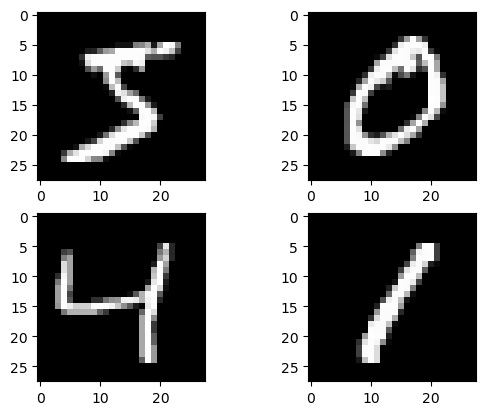

In [6]:
# (X_train, y_train), (X_test, y_test) = mnist.load_data()
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
#
print('X_train.shape before resize and reshape: ' , X_train.shape)

plt.subplot(221)
plt.imshow(X_train[0], cmap=plt.get_cmap('gray'))
plt.subplot(222)
plt.imshow(X_train[1], cmap=plt.get_cmap('gray'))
plt.subplot(223)
plt.imshow(X_train[2], cmap=plt.get_cmap('gray'))
plt.subplot(224)
plt.imshow(X_train[3], cmap=plt.get_cmap('gray'))
# show the plot
plt.show()

In [ ]:
X_train_resize, X_test_resize = X_train,X_test

num_pixels = X_train_resize.shape[1] * X_train_resize.shape[2]

X_train_resize = X_train_resize.reshape(X_train_resize.shape[0], num_pixels).astype('float32')
X_test_resize = X_test_resize.reshape(X_test_resize.shape[0], num_pixels).astype('float32')


print('X_train.shape after resize and reshape: ' , X_train_resize.shape)

# normalize inputs from 0-255 to 0-1
X_train_resize = X_train_resize / 255
X_test_resize = X_test_resize / 255

# one hot encode outputs
# y_train = np_utils.to_categorical(y_train)
# Y_train = np_utils.to_categorical(y_train)
# Y_test = np_utils.to_categorical(y_test)

# num_classes = Y_test.shape[1]

X_train.shape after resize and reshape:  (60000, 784)


In [8]:
best_depth = 16
clf = DecisionTreeClassifier(max_depth=best_depth,random_state=seed)
clf.fit(X_train_resize, y_train)
# clf = clf_new

train_preds_baseline = clf.predict(X_train_resize)
val_preds_baseline = clf.predict(X_test_resize)
acc_baseline_train = acc(train_preds_baseline, y_train)
acc_baseline_val = acc(val_preds_baseline, y_test)

print(f'Training accuracy for our baseline (using all pixel features): {acc_baseline_train}%')
print(f'Validation accuracy for our baseline (using all pixel features): {acc_baseline_val}%')


Training accuracy for our baseline (using all pixel features): 98.83%
Validation accuracy for our baseline (using all pixel features): 88.11%


In [9]:

Y_train = to_categorical(y_train)
Y_test = to_categorical(y_test)

In [10]:
class Mnist_dataset(Dataset):
    def __init__(self, X_train, X_test, y_train, y_test, train_flag = 1):
        if train_flag:
            self.X_data = X_train
            self.y_data = y_train
        else:
            self.X_data = X_test
            self.y_data = y_test

    def __len__(self):
        return len(self.y_data)

    def __getitem__(self, idx):
        Y = self.y_data[idx,:]
        X = self.X_data[idx,:]
        return X, Y

In [11]:
test_loader = torch.utils.data.DataLoader(
        Mnist_dataset(X_train_resize,
                        X_test_resize,
                        Y_train,
                        Y_test,
                        train_flag=0),
        batch_size=100,
        shuffle=False,
    )

In [12]:
args = {}
# args['input_dim'] = 7 * 7    # the number of input dimensions
args['output_dim'] = 10        # the number of outputs (i.e., # classes on MNIST)
args['input_dim'] = num_pixels    # the number of input dimensions
args['depth'] = 16           # tree depth
args['lamda'] = 1e-4           # coefficient of the regularization term
args['lr'] = 1e-4              # learning rate 1e-3
args['weight_decaly'] = 0      # weight decay 5e-5
args['batch_size'] = 100       # batch size
args['epochs'] = 100            # the number of training epochs
args['log_interval'] = 100     # the number of batches to wait before printing logs
args['use_cuda'] = True       # whether to use GPU
device = torch.device("cuda:0" if args['use_cuda'] else "cpu")

In [20]:
tree_depth = 16
model_accuracy = 90.95
# clf = load('./sdt_model/'+str(tree_depth)+'_dt_.joblib')
node_path_left_right,node_depth = get_tree_path(clf)
args['use_cuda'] = False
tree = SDT(clf,node_depth,node_path_left_right,args)
clf_save_path = './sdt_model/'+str(tree_depth)+'_sdt.pth'
# clf_save_path = './sdt_model/'+str(tree_depth)+'_model_'+str(model_accuracy)+'.pth'
tree.load_state_dict(torch.load(clf_save_path))
tree.eval()

SDT(
  (dropout): Dropout(p=0.25, inplace=False)
)

In [21]:
tree

SDT(
  (dropout): Dropout(p=0.25, inplace=False)
)

In [58]:
tree.node_gain = nn.Parameter(data=torch.ones(tree.node_gain.shape)*(-10),requires_grad=False)

In [83]:
tree

SDT(
  (dropout): Dropout(p=0.25, inplace=False)
)

In [ ]:
# row: path
# column: depth
# values: node index corresponding to sklearn tree clf.tree_.feature
print(tree['node_path_left_right'].shape)
tree['node_path_left_right'][:,:,0]

(3233, 16, 2)


array([[   0,    1,    2, ...,   13,   14,   15],
       [   0,    1,    2, ...,   13,   14,   15],
       [   0,    1,    2, ...,   13,   14,   18],
       ...,
       [   0, 3800, 5226, ...,    0,    0,    0],
       [   0, 3800, 5226, ...,    0,    0,    0],
       [   0, 3800, 5226, ...,    0,    0,    0]])

In [ ]:
# row: path
# column: depth
# values: feature index, need to consider tree's leaf_depth, 
clf.tree_.feature[tree['node_path_left_right'][:,:,0]]

array([[350, 568, 430, ..., 461, 639, 151],
       [350, 568, 430, ..., 461, 639, 151],
       [350, 568, 430, ..., 461, 639, 326],
       ...,
       [350, 489, 234, ..., 350, 350, 350],
       [350, 489, 234, ..., 350, 350, 350],
       [350, 489, 234, ..., 350, 350, 350]], dtype=int64)

In [ ]:
# -2 means leaf node just as the set in sklearn
# e.g. for the last leaf on the last row, the leaf depth is 10, so the values at the right of "-2" is meaningless
clf.tree_.feature[tree['node_path_left_right'][:,:,0]][-1,:]

array([350, 489, 234, 658, 515, 319, 294, 441, 407, 148,  -2, 350, 350,
       350, 350, 350], dtype=int64)

In [ ]:
# row: path
# column: depth
# values: left children: 0, right children: 1 , also need to consider tree's leaf_depth
print(tree['node_path_left_right'].shape)
tree['node_path_left_right'][:,:,1]

(3233, 16, 2)


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 1, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])

In [121]:
# leaf depth for each row/path
print(tree['leaf_depth'].shape)
tree['leaf_depth']

(3233,)


array([16, 16, 16, ..., 11, 11, 10])

In [104]:
output_tree = {
    "leaf_depth":tree.leaf_depth,
    "node_path_left_right":tree.node_path_left_right,
    "leaf_depth":tree.leaf_depth
                   
                   }

In [97]:

f_save = open('soft_decision_tree_16_mnist.pkl', 'wb')
pickle.dump(output_tree, f_save)
f_save.close()

In [16]:
f_read = open('soft_decision_tree_16_mnist.pkl', 'rb')
tree = pickle.load(f_read)
print(tree)
f_read.close()

{'leaf_depth': array([16, 16, 16, ..., 11, 11, 10]), 'node_path_left_right': array([[[   0,    0],
        [   1,    0],
        [   2,    0],
        ...,
        [  13,    0],
        [  14,    0],
        [  15,    0]],

       [[   0,    0],
        [   1,    0],
        [   2,    0],
        ...,
        [  13,    0],
        [  14,    0],
        [  15,    1]],

       [[   0,    0],
        [   1,    0],
        [   2,    0],
        ...,
        [  13,    0],
        [  14,    1],
        [  18,    0]],

       ...,

       [[   0,    1],
        [3800,    1],
        [5226,    1],
        ...,
        [   0,    0],
        [   0,    0],
        [   0,    0]],

       [[   0,    1],
        [3800,    1],
        [5226,    1],
        ...,
        [   0,    0],
        [   0,    0],
        [   0,    0]],

       [[   0,    1],
        [3800,    1],
        [5226,    1],
        ...,
        [   0,    0],
        [   0,    0],
        [   0,    0]]])}


array([[350, 568, 430, ..., 461, 639, 151],
       [350, 568, 430, ..., 461, 639, 151],
       [350, 568, 430, ..., 461, 639, 326],
       ...,
       [350, 489, 234, ..., 350, 350, 350],
       [350, 489, 234, ..., 350, 350, 350],
       [350, 489, 234, ..., 350, 350, 350]], dtype=int64)

In [19]:
# dump(clf, './sdt_model/'+str(tree_depth)+'_dt_.joblib') 

['./sdt_model/16_dt_.joblib']

In [39]:
noisy_data = data + torch.tensor(np.random.randn(data.shape[0],data.shape[1])*noise_level,device=device)
noise_level

0.5

In [50]:
X_test_noisy = X_test_resize + np.random.randn(X_test_resize.shape[0],X_test_resize.shape[1])*noise_level

In [51]:
# clf_new = load('./srf_model/'+str(best_depth)+'_dt_.joblib') 
# clf_rf_new = load('./srf_model/'+str(best_depth)+'_rf_.joblib')
# node_depth,node_path_left_right = tree_path(clf_new)
# load_tree = SDT(clf_new,node_depth,node_path_left_right,args)
# load_rf = SRF(clf_rf_new,args)
# # load_tree.load_state_dict(torch.load(clf_save_path))
# load_rf.load_state_dict(torch.load(clf_rf_save_path))
# # load_tree.eval()
# load_rf.eval()
args['use_cuda'] = True  
n = 10000
X_test_tensor = torch.tensor(X_test_resize[:n,:])
tree_depth=16
noise_type = 0 # uniform 1 gaussian 0
noise_flag = 0 # noisy data 0 
acc_all = pd.DataFrame()
for noise_level in tqdm(np.arange(0,0.55,0.1)):
    for i in tqdm(range(10)):
        # clf_new = joblib.load('./sdt_models/'+'credit_'+str(best_depth)+'_dt_.joblib') 
        # clf_new = joblib.load('./sdt_models/'+'bankmarketing_'+str(best_depth)+'_dt_.joblib') 
        # rf_new = joblib.load('./sdt_models/'+'bankmarketing_'+str(best_depth)+'_rf_'+str(np.round(accuracy,2))+'.joblib')

        # clf_new = load('./srf_model/'+str(best_depth)+'_dt.joblib') 
        # clf_rf_new = load('./srf_model/'+str(best_depth)+'_rf.joblib') 
        clf_new = load('./sdt_model/'+str(tree_depth)+'_dt_.joblib') 
        # clf_new  =clf
        # clf_rf_new = load('./srf_model/'+str(best_depth)+'_rf.joblib')


        # clf_new = joblib.load('./sdt_models/'+'bankmarketing_'+str(best_depth)+'_dt_'+str(np.round(accuracy,2))+'.joblib') 
        # clf_new = joblib.load('./sdt_models/'+'Diabetes_'+str(best_depth)+'_dt_.joblib') 
        # clf_new = joblib.load('./sdt_models/'+'clients_'+str(best_depth)+'_dt_.joblib') 
        correct = 0.
        
        load_tree = SDT(clf_new,node_depth,node_path_left_right,args)
        # load_rf = SRF(clf_rf_new,args)



        # load_tree = SDT(rf_new,node_depth,node_path_left_right,args)
        # load_tree = SRF(rf_new,args)
        if args['use_cuda']:
            load_tree.load_state_dict(torch.load(clf_save_path))
            # load_rf.load_state_dict(torch.load(clf_rf_save_path))
            load_tree = load_tree.to(device)
            # load_rf = load_rf.to(device)
        else:
            load_tree.load_state_dict(torch.load(clf_save_path,map_location=torch.device('cpu') ))
            # load_rf.load_state_dict(torch.load(clf_rf_save_path,map_location=torch.device('cpu') ))
        load_tree.node_gain = nn.Parameter(data=torch.ones(tree.node_gain.shape)*(-10),requires_grad=False)
        load_tree = load_tree.to(device)
        load_tree.eval()
        # load_rf.eval()
        
        if noise_flag:
            if noise_type:
                load_tree.node_threshold.data = load_tree.node_threshold.data.cpu() + torch.tensor(np.random.random(load_tree.node_threshold.data.shape)*noise_level-0.5*noise_level)
                # load_rf.node_threshold.data = load_rf.node_threshold.data.cpu() + torch.tensor(np.random.random(load_rf.node_threshold.data.shape)*noise_level-0.5*noise_level)
            else:
                load_tree.node_threshold.data = load_tree.node_threshold.data.cpu() + torch.tensor(np.random.randn(load_tree.node_threshold.data.shape[0],load_tree.node_threshold.data.shape[1])*noise_level)
                # load_rf.node_threshold.data = load_rf.node_threshold.data.cpu() + torch.tensor(np.random.randn(load_rf.node_threshold.data.shape[0],load_rf.node_threshold.data.shape[1])*noise_level)
        

        

        new_clf = DecisionTreeClassifier(max_depth=best_depth,random_state=seed)
        new_clf.tree_ = clf_new.tree_
        new_clf = deepcopy(clf_new)
        if noise_flag:
            if noise_type:
                new_clf.tree_.threshold[:] = clf_new.tree_.threshold[:] + np.random.random(clf_new.tree_.threshold[:].shape)*noise_level-0.5*noise_level
            else:
                new_clf.tree_.threshold[:] = clf_new.tree_.threshold[:] + np.random.randn(clf_new.tree_.threshold[:].shape[0])*noise_level
            preds_clf = new_clf.predict(X_test_resize)
        else:
            X_test_noisy = X_test_resize + np.random.randn(X_test_resize.shape[0],X_test_resize.shape[1])*noise_level
            preds_clf = new_clf.predict(X_test_noisy)
            
        
        # val_preds_baseline = np.argmax(val_preds_baseline,1)
        acc_clf = acc(preds_clf, torch.argmax(torch.tensor(Y_test),1))
        # acc_baseline_val = acc(val_preds_baseline, torch.argmax(torch.tensor(y_test),1))

        acc_dt = pd.DataFrame([acc_clf],columns=['Accuracy'])
        # acc_dt['Accuracy']=acc_baseline_val
        acc_dt['Model']='DT'
        acc_dt['Noise level']=noise_level
        acc_all = pd.concat((acc_all,acc_dt),axis=0,ignore_index=True)

        # new_rf = RandomForestClassifier(50, min_samples_leaf=3, criterion="gini",random_state=seed,max_depth=best_depth)
        # new_rf = deepcopy(clf_rf_new)

        # for i in range(50):
        #     if noise_type:
        #         new_rf.estimators_[i].tree_.threshold[:] = new_rf.estimators_[i].tree_.threshold[:] + np.random.random(new_rf.estimators_[i].tree_.threshold[:].shape)*noise_level-0.5*noise_level
        #     else:
        #         new_rf.estimators_[i].tree_.threshold[:] = new_rf.estimators_[i].tree_.threshold[:] + np.random.randn(new_rf.estimators_[i].tree_.threshold[:].shape[0])*noise_level
                
        
        # preds_rf = new_rf.predict(X_test_resize)
        # acc_baseline_val = acc(val_preds_baseline, torch.argmax(torch.tensor(y_test),1))
        # acc_clf_rf = acc(preds_rf,torch.argmax(torch.tensor(y_test),1))
        # acc_rf = pd.DataFrame([acc_clf_rf],columns=['Accuracy'])
        # acc_rf['Model']='RF'
        # acc_rf['Noise level']=noise_level
        # acc_all = pd.concat((acc_all,acc_rf),axis=0,ignore_index=True)

        



        correct = 0.
        correct_ = 0.

        # with torch.no_grad():
        #         output = load_tree.forward(X_test_tensor[:n,:])
        #         pred = torch.argmax(output,1)
        #         correct = pred.eq(torch.argmax(target,1)).sum()

        for batch_idx, (data, target) in enumerate(test_loader):

            batch_size = data.size()[0]
            data, target = data.to(device), target.to(device)

            # output = torch.softmax(tree.forward(data),dim=1)
            if noise_flag:
                output = load_tree.forward(data)
            else:
                
                noisy_data = data + torch.tensor(np.random.randn(data.shape[0],data.shape[1])*noise_level,device=device)
                output = load_tree.forward(noisy_data)

            # output_ = load_rf.forward(data)

            pred = torch.argmax(output,1)
            # pred_ = torch.argmax(output_,1)
            correct += pred.eq(torch.argmax(target,1)).sum()
            # correct_ += pred_.eq(torch.argmax(target,1)).sum()
        accuracy_sdt = 100.0 * float(correct) / len(test_loader.dataset)
        # accuracy_srf = 100.0 * float(correct_) / len(test_loader.dataset)
        # print(accuracy)
        # acc_sdt = pd.DataFrame([accuracy,'SDT'],columns=['Accuracy','Model'])
        acc_sdt = pd.DataFrame([accuracy_sdt],columns=['Accuracy'])
        # acc_srf = pd.DataFrame([accuracy_srf],columns=['Accuracy'])
        # acc_sdt['Accuracy']=accuracy
        acc_sdt['Model']='SDT'
        acc_sdt['Noise level']=noise_level
        # acc_srf['Model']='SRF'
        # acc_srf['Noise level']=noise_level

        acc_all = pd.concat((acc_all,acc_sdt),axis=0,ignore_index=True)
        # acc_all = pd.concat((acc_all,acc_srf),axis=0,ignore_index=True)
    # acc_all.append([acc_baseline_val,accuracy])
# print(np.mean(acc_all,0))

100%|██████████| 6/6 [01:04<00:00, 10.80s/it]


In [56]:
acc_all['noise type']='noisy input'

In [57]:
# clf_new = load('./srf_model/'+str(best_depth)+'_dt_.joblib') 
# clf_rf_new = load('./srf_model/'+str(best_depth)+'_rf_.joblib')
# node_depth,node_path_left_right = tree_path(clf_new)
# load_tree = SDT(clf_new,node_depth,node_path_left_right,args)
# load_rf = SRF(clf_rf_new,args)
# # load_tree.load_state_dict(torch.load(clf_save_path))
# load_rf.load_state_dict(torch.load(clf_rf_save_path))
# # load_tree.eval()
# load_rf.eval()
args['use_cuda'] = True  
n = 10000
X_test_tensor = torch.tensor(X_test_resize[:n,:])
tree_depth=16
noise_type = 0 # uniform 1 gaussian 0
noise_flag = 1 # noisy data 0 
# acc_all = pd.DataFrame()
for noise_level in tqdm(np.arange(0,0.55,0.1)):
    for i in tqdm(range(10)):
        # clf_new = joblib.load('./sdt_models/'+'credit_'+str(best_depth)+'_dt_.joblib') 
        # clf_new = joblib.load('./sdt_models/'+'bankmarketing_'+str(best_depth)+'_dt_.joblib') 
        # rf_new = joblib.load('./sdt_models/'+'bankmarketing_'+str(best_depth)+'_rf_'+str(np.round(accuracy,2))+'.joblib')

        # clf_new = load('./srf_model/'+str(best_depth)+'_dt.joblib') 
        # clf_rf_new = load('./srf_model/'+str(best_depth)+'_rf.joblib') 
        clf_new = load('./sdt_model/'+str(tree_depth)+'_dt_.joblib') 
        # clf_new  =clf
        # clf_rf_new = load('./srf_model/'+str(best_depth)+'_rf.joblib')


        # clf_new = joblib.load('./sdt_models/'+'bankmarketing_'+str(best_depth)+'_dt_'+str(np.round(accuracy,2))+'.joblib') 
        # clf_new = joblib.load('./sdt_models/'+'Diabetes_'+str(best_depth)+'_dt_.joblib') 
        # clf_new = joblib.load('./sdt_models/'+'clients_'+str(best_depth)+'_dt_.joblib') 
        correct = 0.
        
        load_tree = SDT(clf_new,node_depth,node_path_left_right,args)
        # load_rf = SRF(clf_rf_new,args)



        # load_tree = SDT(rf_new,node_depth,node_path_left_right,args)
        # load_tree = SRF(rf_new,args)
        if args['use_cuda']:
            load_tree.load_state_dict(torch.load(clf_save_path))
            # load_rf.load_state_dict(torch.load(clf_rf_save_path))
            load_tree = load_tree.to(device)
            # load_rf = load_rf.to(device)
        else:
            load_tree.load_state_dict(torch.load(clf_save_path,map_location=torch.device('cpu') ))
            # load_rf.load_state_dict(torch.load(clf_rf_save_path,map_location=torch.device('cpu') ))
        load_tree.node_gain = nn.Parameter(data=torch.ones(tree.node_gain.shape)*(-10),requires_grad=False)
        load_tree = load_tree.to(device)
        load_tree.eval()
        # load_rf.eval()
        
        if noise_flag:
            if noise_type:
                load_tree.node_threshold.data = load_tree.node_threshold.data.cpu() + torch.tensor(np.random.random(load_tree.node_threshold.data.shape)*noise_level-0.5*noise_level)
                # load_rf.node_threshold.data = load_rf.node_threshold.data.cpu() + torch.tensor(np.random.random(load_rf.node_threshold.data.shape)*noise_level-0.5*noise_level)
            else:
                load_tree.node_threshold.data = load_tree.node_threshold.data.cpu() + torch.tensor(np.random.randn(load_tree.node_threshold.data.shape[0],load_tree.node_threshold.data.shape[1])*noise_level)
                # load_rf.node_threshold.data = load_rf.node_threshold.data.cpu() + torch.tensor(np.random.randn(load_rf.node_threshold.data.shape[0],load_rf.node_threshold.data.shape[1])*noise_level)
        

        

        new_clf = DecisionTreeClassifier(max_depth=best_depth,random_state=seed)
        new_clf.tree_ = clf_new.tree_
        new_clf = deepcopy(clf_new)
        if noise_flag:
            if noise_type:
                new_clf.tree_.threshold[:] = clf_new.tree_.threshold[:] + np.random.random(clf_new.tree_.threshold[:].shape)*noise_level-0.5*noise_level
            else:
                new_clf.tree_.threshold[:] = clf_new.tree_.threshold[:] + np.random.randn(clf_new.tree_.threshold[:].shape[0])*noise_level
            preds_clf = new_clf.predict(X_test_resize)
        else:
            X_test_noisy = X_test_resize + np.random.randn(X_test_resize.shape[0],X_test_resize.shape[1])*noise_level
            preds_clf = new_clf.predict(X_test_noisy)
            
        
        # val_preds_baseline = np.argmax(val_preds_baseline,1)
        acc_clf = acc(preds_clf, torch.argmax(torch.tensor(Y_test),1))
        # acc_baseline_val = acc(val_preds_baseline, torch.argmax(torch.tensor(y_test),1))

        acc_dt = pd.DataFrame([acc_clf],columns=['Accuracy'])
        # acc_dt['Accuracy']=acc_baseline_val
        acc_dt['Model']='DT'
        acc_dt['Noise level']=noise_level
        acc_dt['noise type']='device variation'
        acc_all = pd.concat((acc_all,acc_dt),axis=0,ignore_index=True)

        # new_rf = RandomForestClassifier(50, min_samples_leaf=3, criterion="gini",random_state=seed,max_depth=best_depth)
        # new_rf = deepcopy(clf_rf_new)

        # for i in range(50):
        #     if noise_type:
        #         new_rf.estimators_[i].tree_.threshold[:] = new_rf.estimators_[i].tree_.threshold[:] + np.random.random(new_rf.estimators_[i].tree_.threshold[:].shape)*noise_level-0.5*noise_level
        #     else:
        #         new_rf.estimators_[i].tree_.threshold[:] = new_rf.estimators_[i].tree_.threshold[:] + np.random.randn(new_rf.estimators_[i].tree_.threshold[:].shape[0])*noise_level
                
        
        # preds_rf = new_rf.predict(X_test_resize)
        # acc_baseline_val = acc(val_preds_baseline, torch.argmax(torch.tensor(y_test),1))
        # acc_clf_rf = acc(preds_rf,torch.argmax(torch.tensor(y_test),1))
        # acc_rf = pd.DataFrame([acc_clf_rf],columns=['Accuracy'])
        # acc_rf['Model']='RF'
        # acc_rf['Noise level']=noise_level
        # acc_all = pd.concat((acc_all,acc_rf),axis=0,ignore_index=True)

        



        correct = 0.
        correct_ = 0.

        # with torch.no_grad():
        #         output = load_tree.forward(X_test_tensor[:n,:])
        #         pred = torch.argmax(output,1)
        #         correct = pred.eq(torch.argmax(target,1)).sum()

        for batch_idx, (data, target) in enumerate(test_loader):

            batch_size = data.size()[0]
            data, target = data.to(device), target.to(device)

            # output = torch.softmax(tree.forward(data),dim=1)
            if noise_flag:
                output = load_tree.forward(data)
            else:
                
                noisy_data = data + torch.tensor(np.random.randn(data.shape[0],data.shape[1])*noise_level,device=device)
                output = load_tree.forward(noisy_data)

            # output_ = load_rf.forward(data)

            pred = torch.argmax(output,1)
            # pred_ = torch.argmax(output_,1)
            correct += pred.eq(torch.argmax(target,1)).sum()
            # correct_ += pred_.eq(torch.argmax(target,1)).sum()
        accuracy_sdt = 100.0 * float(correct) / len(test_loader.dataset)
        # accuracy_srf = 100.0 * float(correct_) / len(test_loader.dataset)
        # print(accuracy)
        # acc_sdt = pd.DataFrame([accuracy,'SDT'],columns=['Accuracy','Model'])
        acc_sdt = pd.DataFrame([accuracy_sdt],columns=['Accuracy'])
        # acc_srf = pd.DataFrame([accuracy_srf],columns=['Accuracy'])
        # acc_sdt['Accuracy']=accuracy
        acc_sdt['Model']='SDT'
        acc_sdt['Noise level']=noise_level
        # acc_srf['Model']='SRF'
        # acc_srf['Noise level']=noise_level
        acc_sdt['noise type']='device variation'
        acc_all = pd.concat((acc_all,acc_sdt),axis=0,ignore_index=True)
        # acc_all = pd.concat((acc_all,acc_srf),axis=0,ignore_index=True)
    # acc_all.append([acc_baseline_val,accuracy])
# print(np.mean(acc_all,0))

100%|██████████| 6/6 [00:48<00:00,  8.09s/it]


In [ ]:
# n = 10000
# # clf_new = load('./sdt_model/'+str(tree_depth)+'_dt_.joblib') 
# X_test_tensor = torch.tensor(X_test_resize[:n,:])
# device = 'cpu'
# X_test_tensor = X_test_tensor.to(device)
# # load_tree = load_tree.to(device)
# load_tree = SDT(clf,node_depth,node_path_left_right,args)
# load_tree.load_state_dict(torch.load(clf_save_path))
# # load_rf.load_state_dict(torch.load(clf_rf_save_path))
# load_tree = load_tree.to(device)
# with torch.no_grad():
#         output = load_tree.forward(X_test_tensor[:n,:])
#         pred = torch.argmax(output,1)
#         correct = pred.eq(torch.tensor(y_test)).sum()

In [ ]:
# correct = pred.eq(torch.tensor(y_test)).sum()

In [ ]:
# correct/len(y_test)

tensor(0.6648)

In [ ]:
# torch.argmax(torch.tensor(Y_test),1)

tensor([7, 2, 1,  ..., 4, 5, 6])

In [59]:
acc_all

,Accuracy,Model,Noise level,noise type
0,88.11,DT,0.0,noisy input
1,90.69,SDT,0.0,noisy input
2,88.11,DT,0.0,noisy input
3,90.69,SDT,0.0,noisy input
4,88.11,DT,0.0,noisy input
...,...,...,...,...
235,42.55,SDT,0.5,device variation
236,19.15,DT,0.5,device variation
237,43.49,SDT,0.5,device variation
238,18.28,DT,0.5,device variation


In [37]:
data= pd.read_csv('MNIST_gaussian_noise_SRF.csv')

In [22]:
data

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')

In [41]:
data[(data['Model']=='SRF')&(data['Noise level']==0.1)]['Accuracy'].mean()

89.72200000000001

(0.0, 0.5)

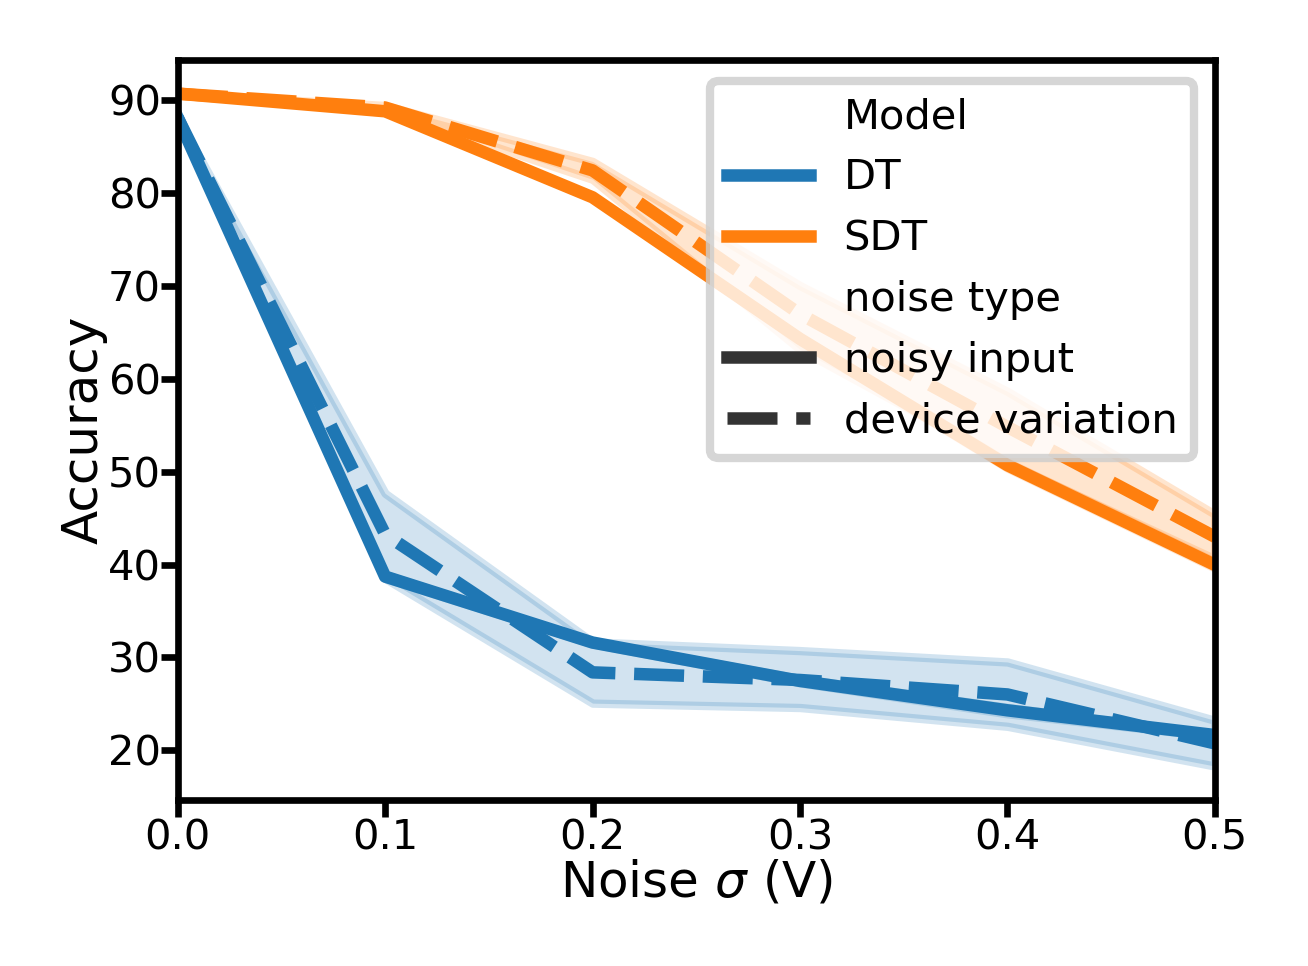

In [61]:
plt.rcParams["svg.fonttype"]='none'
plt.rcParams["font.family"]='Helvetica'
plt.rcParams["savefig.transparent"]=True
plt.style.use('default')
fig, ax = plt.subplots(dpi=600,figsize=(2.28,1.71),layout='tight')
# sns.set_style('whitegrid')
sns.lineplot(data=acc_all,x='Noise level',y='Accuracy',hue='Model',style='noise type')
# if noise_type==0:
    # plt.plot([0.1,0.1],[70,110],'k--')
    # plt.arrow(x=0.1,y=92,dx=-0.07,dy=0,length_includes_head=True,head_width = 0.3,head_length=0.01,fill=True,color='k')
    # plt.text(0.032,92.6,'Exp noise',fontsize=5)
    # plt.xlim(0,.3)
    # plt.ylim(80,102)

# if noise_type==1:
#     plt.plot([0.3,0.3],[70,110],'k--')
#     plt.arrow(x=0.3,y=92,dx=-0.155,dy=0,length_includes_head=True,head_width = 0.3,head_length=0.03,fill=True,color='k')
#     plt.text(0.15,92.6,'Exp noise')
    # plt.xlim(0,.3)
    # plt.ylim(80,102)
    
plt.xlabel('Noise $\sigma$ (V)',fontsize=6,labelpad=0)
plt.ylabel('Accuracy',fontsize=6,labelpad=0)
ax.tick_params(axis='y', which='major', length=2,pad=0,labelsize=5)
ax.tick_params(axis='x', which='major', length=2,pad=0.2,labelsize=5)
# plt.legend(['DT','_','SDT'],fontsize=5,title='Model',title_fontsize=5)
plt.legend(fontsize=5,title_fontsize=5)
# plt.legend(['SDT'],fontsize=5,title='Model',title_fontsize=5)
# plt.savefig('./credit accuracy under uniform noise.svg',transparent=True,dpi=200)

# plt.ylim([30,100])
plt.xlim([0,0.5])

In [29]:
y_test

array([7, 2, 1, ..., 4, 5, 6], dtype=uint8)

In [9]:
pd.DataFrame([end_time - start_time, 'DT', 'Tree Depth'] , columns=['Time(s)','Model','Tree Depth'])

NameError: name 'end_time' is not defined

In [52]:
# time_measured = np.zeros([240,3])
# i = 0
time_measured = []
# for tree_depth_group in np.arange(6,22,2):
for tree_depth_group in [20]:
    

    # time_measured = np.zeros([10,3])
    args['depth'] = tree_depth_group
    tree_depth = args['depth']
    n = 10000
    X_test_tensor = torch.tensor(X_test_resize[:n,:])
    # X_test_tensor = torch.tensor(X_test_resize)
    for times in range(10):
        # for node_depth in np.arange(6,22,2):

            clf = load('./sdt_model/'+str(tree_depth)+'_dt_.joblib')
            node_path_left_right,node_depth = get_tree_path(clf)
            args['use_cuda'] = True
            tree = SDT(clf,node_depth,node_path_left_right,args)
            tree.load_state_dict(torch.load('./sdt_model/'+str(tree_depth)+'_sdt.pth'))
            tree.eval()
            start_time = time.time()
            # val_preds_baseline = clf.predict(X_test_resize)
            val_preds_baseline = clf.predict(X_test_resize[:n,:])
            end_time = time.time()

            # time_measured[i*10+times,0] = end_time - start_time
            # time_measured.append({'Times(s)': end_time - start_time, 'Model': 'DT', 'Tree Depth':tree_depth_group})
            time_measured.append([end_time - start_time,'DT',tree_depth_group])
            # time_measured = pd.concat((time_measured,pd.DataFrame({'Times(s)': end_time - start_time, 'Model': 'DT', 'Tree Depth':tree_depth_group},ignore_index=True)),0)
            device = torch.device("cuda" if args['use_cuda'] else "cpu")
            
            X_test_tensor = X_test_tensor.to(device)
            tree = tree.to(device)
            

            
            
            
            start_time = time.time()
            with torch.no_grad():
                output = tree.forward(X_test_tensor[:n,:])
                pred = torch.argmax(output,1)
            end_time = time.time()
            # time_measured[i*10+times,1] = end_time - start_time
            # time_measured.append({'Times(s)': end_time - start_time, 'Model': 'SDT_CPU', 'Tree Depth':tree_depth_group})
            time_measured.append([end_time - start_time,'SDT_CPU',tree_depth_group])
            args['use_cuda'] = True
            tree = SDT(clf,node_depth,node_path_left_right,args)
            tree.load_state_dict(torch.load('./sdt_model/'+str(tree_depth)+'_sdt.pth'))
            device = torch.device("cuda" if args['use_cuda'] else "cpu")
            X_test_tensor = X_test_tensor.to(device)

            start = torch.cuda.Event(enable_timing=True)
            end = torch.cuda.Event(enable_timing=True)

            start.record()
            with torch.no_grad():
                output = tree.forward(X_test_tensor[:n,:])
                pred = torch.argmax(output,1)
            end.record()


            torch.cuda.synchronize()
            # time_measured[i*10+times,2] = start.elapsed_time(end)*1e-3
            # print(start.elapsed_time(end))
            # time_measured.append({'Times(s)': start.elapsed_time(end)*1e-3, 'Model': 'SDT_GPU', 'Tree Depth':tree_depth_group})

            time_measured.append([start.elapsed_time(end)*1e-3,'SDT_GPU',tree_depth_group])


            del output,pred,tree
            torch.cuda.empty_cache()

    torch.cuda.empty_cache()

    # i = i + 1
    print(tree_depth_group)


        
        


RuntimeError: indices should be either on cpu or on the same device as the indexed tensor (cpu)

In [49]:
tree

SDT(
  (dropout): Dropout(p=0.25, inplace=False)
)

In [50]:
X_test_tensor

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')

In [43]:
time_measured

[[0.007870912551879883, 'DT', 6],
 [0.0510709285736084, 'SDT_CPU', 6],
 [0.02501753616333008, 'SDT_GPU', 6],
 [0.0074100494384765625, 'DT', 6],
 [0.045491933822631836, 'SDT_CPU', 6],
 [0.00539734411239624, 'SDT_GPU', 6],
 [0.006339073181152344, 'DT', 6],
 [0.0254514217376709, 'SDT_CPU', 6],
 [0.005593791961669922, 'SDT_GPU', 6],
 [0.006003379821777344, 'DT', 6],
 [0.04260373115539551, 'SDT_CPU', 6],
 [0.009480768203735352, 'SDT_GPU', 6],
 [0.009900331497192383, 'DT', 6],
 [0.036702632904052734, 'SDT_CPU', 6],
 [0.004790624141693115, 'SDT_GPU', 6],
 [0.006524085998535156, 'DT', 6],
 [0.028994321823120117, 'SDT_CPU', 6],
 [0.004638527870178223, 'SDT_GPU', 6],
 [0.006170749664306641, 'DT', 6],
 [0.019988298416137695, 'SDT_CPU', 6],
 [0.004995200157165527, 'SDT_GPU', 6],
 [0.0061304569244384766, 'DT', 6],
 [0.03367924690246582, 'SDT_CPU', 6],
 [0.0047049918174743655, 'SDT_GPU', 6],
 [0.006518363952636719, 'DT', 6],
 [0.019715547561645508, 'SDT_CPU', 6],
 [0.004870431900024414, 'SDT_GPU', 6

In [75]:
time_measured = [[0.007870912551879883, 'DT', 6],
 [0.0510709285736084, 'SDT_CPU', 6],
 [0.02501753616333008, 'SDT_GPU', 6],
 [0.0074100494384765625, 'DT', 6],
 [0.045491933822631836, 'SDT_CPU', 6],
 [0.00539734411239624, 'SDT_GPU', 6],
 [0.006339073181152344, 'DT', 6],
 [0.0254514217376709, 'SDT_CPU', 6],
 [0.005593791961669922, 'SDT_GPU', 6],
 [0.006003379821777344, 'DT', 6],
 [0.04260373115539551, 'SDT_CPU', 6],
 [0.009480768203735352, 'SDT_GPU', 6],
 [0.009900331497192383, 'DT', 6],
 [0.036702632904052734, 'SDT_CPU', 6],
 [0.004790624141693115, 'SDT_GPU', 6],
 [0.006524085998535156, 'DT', 6],
 [0.028994321823120117, 'SDT_CPU', 6],
 [0.004638527870178223, 'SDT_GPU', 6],
 [0.006170749664306641, 'DT', 6],
 [0.019988298416137695, 'SDT_CPU', 6],
 [0.004995200157165527, 'SDT_GPU', 6],
 [0.0061304569244384766, 'DT', 6],
 [0.03367924690246582, 'SDT_CPU', 6],
 [0.0047049918174743655, 'SDT_GPU', 6],
 [0.006518363952636719, 'DT', 6],
 [0.019715547561645508, 'SDT_CPU', 6],
 [0.004870431900024414, 'SDT_GPU', 6],
 [0.006010532379150391, 'DT', 6],
 [0.020908594131469727, 'SDT_CPU', 6],
 [0.004440927982330322, 'SDT_GPU', 6],
 [0.028474092483520508, 'DT', 8],
 [0.18577051162719727, 'SDT_CPU', 8],
 [0.013657983779907228, 'SDT_GPU', 8],
 [0.0068552494049072266, 'DT', 8],
 [0.12204360961914062, 'SDT_CPU', 8],
 [0.012915200233459472, 'SDT_GPU', 8],
 [0.006913900375366211, 'DT', 8],
 [0.13881278038024902, 'SDT_CPU', 8],
 [0.012670144081115723, 'SDT_GPU', 8],
 [0.007585763931274414, 'DT', 8],
 [0.1721804141998291, 'SDT_CPU', 8],
 [0.012784576416015625, 'SDT_GPU', 8],
 [0.00687861442565918, 'DT', 8],
 [0.11029601097106934, 'SDT_CPU', 8],
 [0.013068863868713379, 'SDT_GPU', 8],
 [0.0068242549896240234, 'DT', 8],
 [0.13897013664245605, 'SDT_CPU', 8],
 [0.013649439811706543, 'SDT_GPU', 8],
 [0.0075452327728271484, 'DT', 8],
 [0.13537335395812988, 'SDT_CPU', 8],
 [0.013624640464782714, 'SDT_GPU', 8],
 [0.007565736770629883, 'DT', 8],
 [0.13228344917297363, 'SDT_CPU', 8],
 [0.013043519973754882, 'SDT_GPU', 8],
 [0.007553577423095703, 'DT', 8],
 [0.15124940872192383, 'SDT_CPU', 8],
 [0.013932224273681642, 'SDT_GPU', 8],
 [0.007621049880981445, 'DT', 8],
 [0.13901567459106445, 'SDT_CPU', 8],
 [0.012989376068115234, 'SDT_GPU', 8],
 [0.01860976219177246, 'DT', 10],
 [0.5519161224365234, 'SDT_CPU', 10],
 [0.03455667114257813, 'SDT_GPU', 10],
 [0.0067195892333984375, 'DT', 10],
 [0.4894583225250244, 'SDT_CPU', 10],
 [0.03837625503540039, 'SDT_GPU', 10],
 [0.0074672698974609375, 'DT', 10],
 [0.522747278213501, 'SDT_CPU', 10],
 [0.03548780822753907, 'SDT_GPU', 10],
 [0.008020401000976562, 'DT', 10],
 [0.467602014541626, 'SDT_CPU', 10],
 [0.03700083160400391, 'SDT_GPU', 10],
 [0.007471561431884766, 'DT', 10],
 [0.46033716201782227, 'SDT_CPU', 10],
 [0.035800254821777344, 'SDT_GPU', 10],
 [0.007455348968505859, 'DT', 10],
 [0.47472119331359863, 'SDT_CPU', 10],
 [0.03568243026733398, 'SDT_GPU', 10],
 [0.007480621337890625, 'DT', 10],
 [0.5006804466247559, 'SDT_CPU', 10],
 [0.03694230270385742, 'SDT_GPU', 10],
 [0.0074367523193359375, 'DT', 10],
 [0.5094144344329834, 'SDT_CPU', 10],
 [0.03589593505859375, 'SDT_GPU', 10],
 [0.007531166076660156, 'DT', 10],
 [0.4492154121398926, 'SDT_CPU', 10],
 [0.03666707229614258, 'SDT_GPU', 10],
 [0.00749659538269043, 'DT', 10],
 [0.5815975666046143, 'SDT_CPU', 10],
 [0.038267360687255864, 'SDT_GPU', 10],
 [0.007208824157714844, 'DT', 12],
 [1.1502714157104492, 'SDT_CPU', 12],
 [0.08250495910644531, 'SDT_GPU', 12],
 [0.0071086883544921875, 'DT', 12],
 [1.2435715198516846, 'SDT_CPU', 12],
 [0.08943833923339845, 'SDT_GPU', 12],
 [0.0077741146087646484, 'DT', 12],
 [1.1824700832366943, 'SDT_CPU', 12],
 [0.08500505828857421, 'SDT_GPU', 12],
 [0.007733583450317383, 'DT', 12],
 [1.1949617862701416, 'SDT_CPU', 12],
 [0.08532621002197266, 'SDT_GPU', 12],
 [0.00750422477722168, 'DT', 12],
 [1.1995151042938232, 'SDT_CPU', 12],
 [0.11683379364013673, 'SDT_GPU', 12],
 [0.007761240005493164, 'DT', 12],
 [1.1953771114349365, 'SDT_CPU', 12],
 [0.09208287811279298, 'SDT_GPU', 12],
 [0.00832509994506836, 'DT', 12],
 [1.1959645748138428, 'SDT_CPU', 12],
 [0.08676022338867187, 'SDT_GPU', 12],
 [0.007951736450195312, 'DT', 12],
 [1.2213704586029053, 'SDT_CPU', 12],
 [0.08532262420654298, 'SDT_GPU', 12],
 [0.007850885391235352, 'DT', 12],
 [1.2041668891906738, 'SDT_CPU', 12],
 [0.08362185668945313, 'SDT_GPU', 12],
 [0.0077478885650634766, 'DT', 12],
 [1.2012574672698975, 'SDT_CPU', 12],
 [0.08618854522705079, 'SDT_GPU', 12],
 [0.012137174606323242, 'DT', 14],
 [2.104172945022583, 'SDT_CPU', 14],
 [0.12950288391113282, 'SDT_GPU', 14],
 [0.008056163787841797, 'DT', 14],
 [2.1374051570892334, 'SDT_CPU', 14],
 [0.17365350341796876, 'SDT_GPU', 14],
 [0.0074536800384521484, 'DT', 14],
 [2.040036201477051, 'SDT_CPU', 14],
 [0.13711567687988283, 'SDT_GPU', 14],
 [0.00814199447631836, 'DT', 14],
 [2.0312721729278564, 'SDT_CPU', 14],
 [0.13725978088378907, 'SDT_GPU', 14],
 [0.007886409759521484, 'DT', 14],
 [2.043018341064453, 'SDT_CPU', 14],
 [0.13488000488281252, 'SDT_GPU', 14],
 [0.007553577423095703, 'DT', 14],
 [2.1366913318634033, 'SDT_CPU', 14],
 [0.1289167022705078, 'SDT_GPU', 14],
 [0.007346391677856445, 'DT', 14],
 [2.170344114303589, 'SDT_CPU', 14],
 [0.1324238739013672, 'SDT_GPU', 14],
 [0.00802922248840332, 'DT', 14],
 [2.1420254707336426, 'SDT_CPU', 14],
 [0.1477427215576172, 'SDT_GPU', 14],
 [0.007796525955200195, 'DT', 14],
 [2.157541513442993, 'SDT_CPU', 14],
 [0.18407315063476562, 'SDT_GPU', 14],
 [0.007405281066894531, 'DT', 14],
 [2.0958619117736816, 'SDT_CPU', 14],
 [0.13748019409179688, 'SDT_GPU', 14],
 [0.007661342620849609, 'DT', 16],
 [2.6555938720703125, 'SDT_CPU', 16],
 [0.17155068969726564, 'SDT_GPU', 16],
 [0.0075531005859375, 'DT', 16],
 [2.760063648223877, 'SDT_CPU', 16],
 [0.14293580627441407, 'SDT_GPU', 16],
 [0.005671501159667969, 'DT', 16],
 [2.8406288623809814, 'SDT_CPU', 16],
 [0.18197718811035157, 'SDT_GPU', 16],
 [0.008065223693847656, 'DT', 16],
 [2.7141945362091064, 'SDT_CPU', 16],
 [0.18234815979003907, 'SDT_GPU', 16],
 [0.007614612579345703, 'DT', 16],
 [2.723130702972412, 'SDT_CPU', 16],
 [0.1706892852783203, 'SDT_GPU', 16],
 [0.007483959197998047, 'DT', 16],
 [3.1605095863342285, 'SDT_CPU', 16],
 [0.17937484741210938, 'SDT_GPU', 16],
 [0.007938861846923828, 'DT', 16],
 [2.8097572326660156, 'SDT_CPU', 16],
 [0.1930768280029297, 'SDT_GPU', 16],
 [0.007700681686401367, 'DT', 16],
 [2.801445960998535, 'SDT_CPU', 16],
 [0.17912246704101562, 'SDT_GPU', 16],
 [0.008031845092773438, 'DT', 16],
 [2.765923261642456, 'SDT_CPU', 16],
 [0.17933946228027345, 'SDT_GPU', 16],
 [0.007350921630859375, 'DT', 16],
 [2.769911766052246, 'SDT_CPU', 16],
 [0.17268031311035156, 'SDT_GPU', 16],
 [0.007657766342163086, 'DT', 18],
 [3.438800811767578, 'SDT_CPU', 18],
 [0.23503768920898438, 'SDT_GPU', 18],
 [0.007679462432861328, 'DT', 18],
 [3.3135721683502197, 'SDT_CPU', 18],
 [0.2187631072998047, 'SDT_GPU', 18],
 [0.008208751678466797, 'DT', 18],
 [3.5617494583129883, 'SDT_CPU', 18],
 [0.23134931945800782, 'SDT_GPU', 18],
 [0.008274316787719727, 'DT', 18],
 [3.6714186668395996, 'SDT_CPU', 18],
 [0.2283573455810547, 'SDT_GPU', 18],
 [0.007552146911621094, 'DT', 18],
 [3.4698688983917236, 'SDT_CPU', 18],
 [0.20304873657226563, 'SDT_GPU', 18],
 [0.007967233657836914, 'DT', 18],
 [3.297227382659912, 'SDT_CPU', 18],
 [0.2083830108642578, 'SDT_GPU', 18],
 [0.007569313049316406, 'DT', 18],
 [3.2842986583709717, 'SDT_CPU', 18],
 [0.22382086181640626, 'SDT_GPU', 18],
 [0.008133172988891602, 'DT', 18],
 [3.3847947120666504, 'SDT_CPU', 18],
 [0.21237132263183595, 'SDT_GPU', 18],
 [0.017887592315673828, 'DT', 18],
 [3.581116199493408, 'SDT_CPU', 18],
 [0.22322486877441405, 'SDT_GPU', 18],
 [0.007436990737915039, 'DT', 18],
 [3.383155584335327, 'SDT_CPU', 18],
 [0.29608303833007815, 'SDT_GPU', 18],
 [0.00791168212890625, 'DT', 20],
 [3.800124406814575, 'SDT_CPU', 20],
 [0.23276396179199219, 'SDT_GPU', 20],
 [0.007651329040527344, 'DT', 20],
 [3.780782699584961, 'SDT_CPU', 20],
 [0.2506153259277344, 'SDT_GPU', 20],
 [0.0077381134033203125, 'DT', 20],
 [3.8767244815826416, 'SDT_CPU', 20],
 [0.2610328369140625, 'SDT_GPU', 20],
 [0.007831811904907227, 'DT', 20],
 [3.8431921005249023, 'SDT_CPU', 20],
 [0.23604345703125001, 'SDT_GPU', 20],
 [0.008182287216186523, 'DT', 20],
 [3.7810070514678955, 'SDT_CPU', 20],
 [0.23607958984375, 'SDT_GPU', 20],
 [0.007450103759765625, 'DT', 20],
 [3.7995691299438477, 'SDT_CPU', 20],
 [0.2668851623535156, 'SDT_GPU', 20],
 [0.008237123489379883, 'DT', 20],
 [3.7516119480133057, 'SDT_CPU', 20],
 [0.24037855529785157, 'SDT_GPU', 20],
 [0.007580995559692383, 'DT', 20],
 [4.093017578125, 'SDT_CPU', 20],
 [0.23989010620117188, 'SDT_GPU', 20],
 [0.008083343505859375, 'DT', 20],
 [3.813929796218872, 'SDT_CPU', 20],
 [0.24687872314453124, 'SDT_GPU', 20],
 [0.007687568664550781, 'DT', 20],
 [4.199172258377075, 'SDT_CPU', 20],
 [0.24700947570800783, 'SDT_GPU', 20]]

In [76]:
def time_FG_CAM(depth):
    # time for CAM is 3*10ns
    # time for WTA is about 3 ns
    t_WTA = 0.053973*(depth-1)+2.69
    return (t_WTA+10)*1e-9*1e4

In [77]:
accelerated = []

for depth in np.arange(6,22,2):
    label = 'DT_FG-CAM'
    accelerated.append([10*1e-9*1e4,label,depth])
    label = 'SDT_FG-CAM'
    accelerated.append([time_FG_CAM(depth),label,depth])

In [58]:
depth

20

In [59]:
np.power(2,6)

64

In [78]:
data_complexity=[]
for depth in np.arange(6,22,1):
    label = 'DT'
    data_complexity.append([depth,label,depth])
    label = 'SDT'
    data_complexity.append([np.power(2,depth),label,depth])


In [79]:
complexity = pd.DataFrame(data_complexity,columns=['Time(s)','Model','Tree Depth'])

In [80]:
accelerated

[[0.0001, 'DT_FG-CAM', 6],
 [0.00012959865, 'SDT_FG-CAM', 6],
 [0.0001, 'DT_FG-CAM', 8],
 [0.00013067811, 'SDT_FG-CAM', 8],
 [0.0001, 'DT_FG-CAM', 10],
 [0.00013175757000000003, 'SDT_FG-CAM', 10],
 [0.0001, 'DT_FG-CAM', 12],
 [0.00013283703, 'SDT_FG-CAM', 12],
 [0.0001, 'DT_FG-CAM', 14],
 [0.00013391649000000003, 'SDT_FG-CAM', 14],
 [0.0001, 'DT_FG-CAM', 16],
 [0.00013499595, 'SDT_FG-CAM', 16],
 [0.0001, 'DT_FG-CAM', 18],
 [0.00013607541, 'SDT_FG-CAM', 18],
 [0.0001, 'DT_FG-CAM', 20],
 [0.00013715487, 'SDT_FG-CAM', 20]]

In [81]:

# accelerated = [
#         [(10)*1e-5,'DT_FG-CAM',6],
#     [(10)*1e-5,'DT_FG-CAM',8],
#     [(10)*1e-5,'DT_FG-CAM',10],
#     [(10)*1e-5,'DT_FG-CAM',12],
#     [(10)*1e-5,'DT_FG-CAM',14],
#     [(10)*1e-5,'DT_FG-CAM',16],
#     [(10)*1e-5,'DT_FG-CAM',18],
#     [(10)*1e-5,'DT_FG-CAM',20],
#     [(10+5*6)*1e-5,'SDT_FG-CAM',6],
#     [(10+5*8)*1e-5,'SDT_FG-CAM',8],
#     [(10+5*10)*1e-5,'SDT_FG-CAM',10],
#     [(10+5*12)*1e-5,'SDT_FG-CAM',12],
#     [(10+5*14)*1e-5,'SDT_FG-CAM',14],
#     [(10+5*16)*1e-5,'SDT_FG-CAM',16],
#     [(10+5*18)*1e-5,'SDT_FG-CAM',18],
#     [(10+5*20)*1e-5,'SDT_FG-CAM',20]


# accelerated = [
#     [(10+5*6)*1e-5,'SDT_FG-CAM',6],
#     [(10+5*8)*1e-5,'SDT_FG-CAM',8],
#     [(10+5*10)*1e-5,'SDT_FG-CAM',10],
#     [(10+5*12)*1e-5,'SDT_FG-CAM',12],
#     [(10+5*14)*1e-5,'SDT_FG-CAM',14],
#     [(10+5*16)*1e-5,'SDT_FG-CAM',16],
#     [(10+5*18)*1e-5,'SDT_FG-CAM',18],
#     [(10+5*20)*1e-5,'SDT_FG-CAM',20]
# ]
# accelerated = [
#     [300*1e-5,'SDT_FG-CAM',6],
#     [300*1e-5,'SDT_FG-CAM',8],
#     [300*1e-5,'SDT_FG-CAM',10],
#     [300*1e-5,'SDT_FG-CAM',12],
#     [300*1e-5,'SDT_FG-CAM',14],
#     [300*1e-5,'SDT_FG-CAM',16],
#     [300*1e-5,'SDT_FG-CAM',18],
#     [300*1e-5,'SDT_FG-CAM',20]
# ]

data_acc = pd.DataFrame(accelerated,columns=['Time(s)','Model','Tree Depth'])


In [82]:
data = pd.DataFrame(time_measured,columns=['Time(s)','Model','Tree Depth'])
data = pd.concat((data,data_acc),axis=0,ignore_index=True)

In [83]:
data['Time(s)'] = data['Time(s)']/10000
data['Time(ms)'] = data['Time(s)']*1000

In [84]:
data.loc[data['Model']=="SDT_CPU",'Model']="SDT"

In [85]:
data.loc[data['Model']=="SDT",'Model']="SDT_CPU"

In [86]:
data.loc[data['Model']=="DT",'Model']="DT_CPU"

In [87]:
data[(data['Tree Depth']==20)&(data['Model']=='SDT_FG-CAM')]['Time(ms)'].mean()*1e6

13.715487000000001

In [88]:
data[(data['Tree Depth']==20)&(data['Model']=='DT_FG-CAM')]['Time(ms)'].mean()*1e6

10.0

In [89]:
data[(data['Tree Depth']==20)&(data['Model']=='SDT_CPU')]['Time(ms)'].mean()*1e6

387391.31450653076

In [90]:
data[(data['Tree Depth']==20)&(data['Model']=='DT_CPU')]['Time(ms)'].mean()*1e6

783.5435867309571

In [91]:
data[(data['Tree Depth']==20)&(data['Model']=='SDT_GPU')]['Time(ms)'].mean()*1e6

24575.77194213867

findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.


findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: 

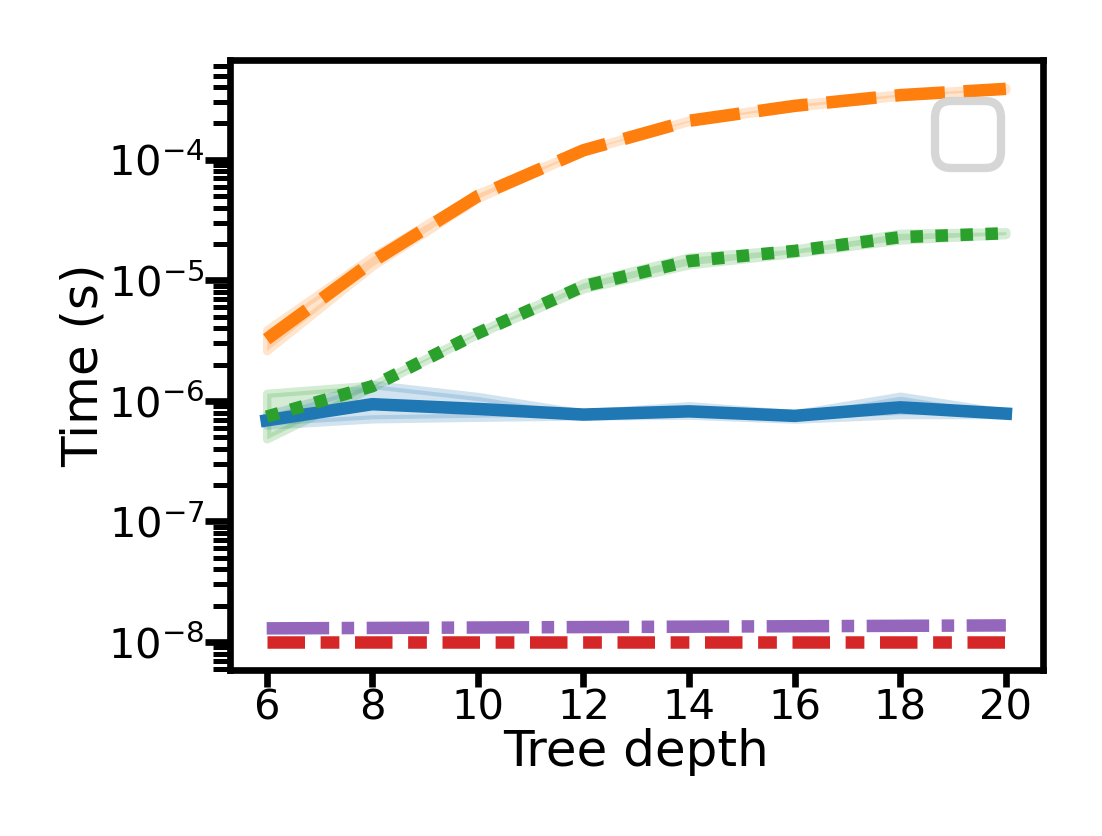

In [92]:
plt.style.use('default')
plt.rcParams["svg.fonttype"]='none'
plt.rcParams["font.family"]='Helvetica'
plt.rcParams["savefig.transparent"]=True
# 
fig, ax = plt.subplots(dpi=600,figsize=(1.76,1.32))
ax.set_box_aspect(1.32/1.76)
ax.set_xlabel('Tree depth',fontsize=6,labelpad=0)
ax.set_ylabel('Time (s)',fontsize=6,labelpad=0)
g_results = sns.lineplot(ax=ax, data = data[data['Tree Depth']<22], x='Tree Depth',y='Time(s)', hue='Model',style='Model')
g_results.set(yscale='log')
ax.tick_params(axis='y', which='major', length=3,pad=0,labelsize=5)
ax.tick_params(axis='x', which='major', length=2,pad=0.2,labelsize=5)
plt.legend([])
plt.xticks([6,8,10,12,14,16,18,20])
plt.savefig('./images/inference time.svg',format='svg',transparent=True)
# plt.savefig('./images/analysis2.svg',format='svg',transparent=True,bbox_inches='tight')
# plt.savefig('./images/analysis2.png',format='png',transparent=True,bbox_inches='tight',dpi=600)

findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: 

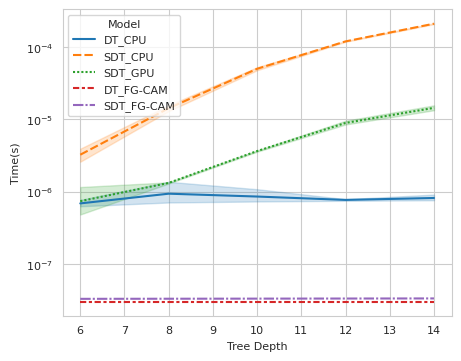

In [18]:
plt.style.use('default')
plt.rcParams["svg.fonttype"]='none'
plt.rcParams["font.family"]='Helvetica'
plt.rcParams["savefig.transparent"]=True
# 
fig, ax = plt.subplots(dpi=600,figsize=(1.76,1.32))
ax.set_box_aspect(1.32/1.76)

# ax = ax.flatten()

# sns.set_style('whitegrid')

g_results = sns.lineplot(ax=ax, data = data[data['Tree Depth']<16], x='Tree Depth',y='Time(s)', hue='Model',style='Model')
g_results.set(yscale='log')
plt.tick_params(axis='both', which='major')
plt.savefig('./images/analysis2.svg',format='svg',transparent=True,bbox_inches='tight')
plt.savefig('./images/analysis2.png',format='png',transparent=True,bbox_inches='tight',dpi=600)

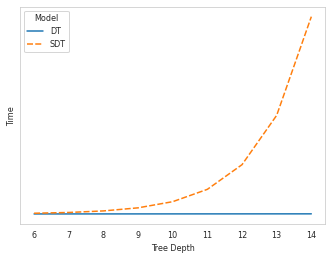

In [90]:
fig, ax  = plt.subplots(figsize=(4.5,3.5),constrained_layout=True)
# ax = ax.flatten()
plt.rcParams["font.family"] = "Helvetica"
plt.rcParams.update({'font.size': 8})
sns.set_style('whitegrid')

g_results = sns.lineplot(ax=ax, data = complexity[complexity['Tree Depth']<15], x='Tree Depth',y='Time(s)', hue='Model',style='Model')
# g_results.set(yscale='log')
plt.grid(False)
plt.yticks([])
plt.ylabel('Time')
plt.tick_params(axis='both', which='major')
plt.savefig('./images/analysis3.svg',format='svg',transparent=True,bbox_inches='tight')


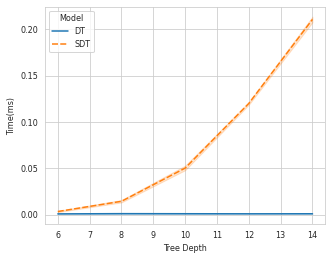

In [74]:
fig, ax  = plt.subplots(figsize=(4.5,3.5),constrained_layout=True)
# ax = ax.flatten()
plt.rcParams["font.family"] = "Helvetica"
plt.rcParams.update({'font.size': 8})
sns.set_style('whitegrid')

g_results = sns.lineplot(ax=ax, data = data[(data['Tree Depth']<16)&(data['Model']!='SDT_GPU')], x='Tree Depth',y='Time(ms)', hue='Model',style='Model')
# g_results.set(yscale='log')
plt.tick_params(axis='both', which='major')
# plt.ylim([0,0.00005])
# plt.savefig('./images/analysis2.svg',format='svg',transparent=True,bbox_inches='tight')
# plt.savefig('./images/analysis2.png',format='png',transparent=True,bbox_inches='tight',dpi=600)

In [66]:
np.mean(time_measured,0)

array([0.00581949, 3.00222955, 0.17463139])

In [47]:
np.mean(time_measured,0)

array([0.00653834, 3.093768  , 0.17810581])

In [64]:
clf.tree_.feature

array([350, 568, 430, ..., 146,  -2,  -2], dtype=int64)

In [65]:
sum(clf.tree_.feature!=-2)

3585

In [30]:
X_test_resize[:1,:].shape

(1, 784)

In [15]:
load_path = './sdt_model/16_model_90.95.pth'

load_tree = SDT(clf,node_depth,node_path_left_right,args)
load_tree.load_state_dict(torch.load(load_path))
load_tree.eval()

SDT(
  (dropout): Dropout(p=0.25, inplace=False)
)

(array([9.000e+00, 4.400e+01, 1.440e+02, 1.264e+03, 4.974e+03, 2.900e+01,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([-12.447349 , -11.86075  , -11.274151 , -10.687552 , -10.100954 ,
         -9.514355 ,  -8.927756 ,  -8.341158 ,  -7.754559 ,  -7.1679606,
         -6.581362 ], dtype=float32),
 <BarContainer object of 10 artists>)

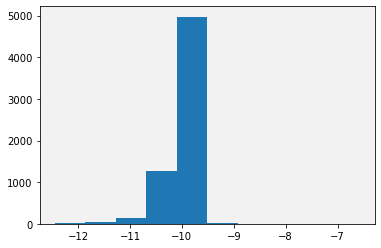

In [19]:
plt.hist(load_tree.node_gain.data.reshape(1,-1))

In [25]:
X_test_noise = X_test_resize.copy()
root_feature = clf.tree_.feature[0]
X_test_noise[:,root_feature] = np.random.random(X_test_noise[:,root_feature].shape)




test_loader_noise = torch.utils.data.DataLoader(
        Mnist_dataset(X_train_resize,
                        X_test_noise,
                        Y_train,
                        Y_test,
                        train_flag=0),
        batch_size=100,
        shuffle=False,
    )

In [26]:
tree.eval()
correct = 0.

for batch_idx, (data, target) in enumerate(test_loader_noise):

    batch_size = data.size()[0]
    data, target = data.to(device), target.to(device)

    # output = torch.softmax(tree.forward(data),dim=1)
    output = tree.forward(data)
    pred = torch.argmax(output,1)
    correct += pred.eq(torch.argmax(target,1)).sum()
accuracy = 100.0 * float(correct) / len(test_loader.dataset)
print(accuracy)

88.58


In [80]:

val_preds_baseline = clf.predict(X_test_noise)
acc_baseline_val = acc(val_preds_baseline, y_test)
print(f'Validation accuracy for our baseline (using all pixel features) under noise: {acc_baseline_val}%')

Validation accuracy for our baseline (using all pixel features) under noise: 74.01%


In [36]:
thres_mean = torch.mean(tree.node_threshold.data)
thres_std = torch.std(tree.node_threshold.data)

tensor(0.1406)

(array([2.8330e+03, 0.0000e+00, 4.2000e+01, 2.9100e+02, 1.5170e+04,
        1.8545e+04, 1.3225e+04, 1.5920e+03, 2.6000e+01, 4.0000e+00]),
 array([-2.        , -1.5833483 , -1.1666967 , -0.75004494, -0.33339328,
         0.08325839,  0.49991006,  0.9165617 ,  1.3332134 ,  1.749865  ,
         2.1665168 ], dtype=float32),
 <BarContainer object of 10 artists>)

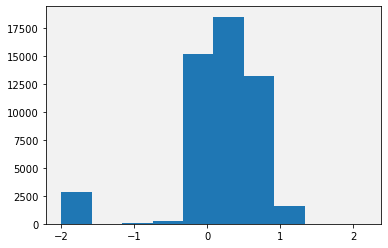

In [40]:
plt.hist(tree.node_threshold.data.reshape(1,-1))

In [43]:
tree.node_threshold.data = load_tree.node_threshold.data + torch.tensor(np.random.random(tree.node_threshold.data.shape)*0.2-0.1)

In [47]:
new_clf = DecisionTreeClassifier(max_depth=best_depth)
new_clf.tree_ = clf.tree_

In [81]:
from copy import deepcopy
new_clf = deepcopy(clf)

(array([3233.,    0.,    0.,    0.,    0.,    0.,  806.,  879.,  754.,
         793.]),
 array([-2.        , -1.70019608, -1.40039216, -1.10058824, -0.80078431,
        -0.50098039, -0.20117647,  0.09862745,  0.39843137,  0.69823529,
         0.99803922]),
 <BarContainer object of 10 artists>)

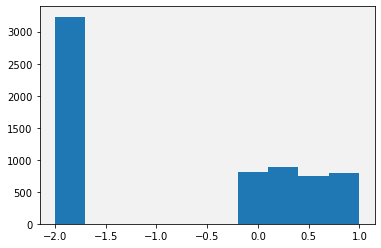

In [50]:
plt.hist(clf.tree_.threshold)

In [53]:
new_clf.tree_.threshold.data.shape

(6465,)

In [78]:
new_clf.cla

AttributeError: 'DecisionTreeClassifier' object has no attribute 'classes_'

In [82]:
new_clf.tree_.threshold[:] = clf.tree_.threshold[:] + np.random.random(clf.tree_.threshold[:].shape)*0.2-0.1

In [79]:
val_preds_baseline = new_clf.predict(X_test_noise)
acc_baseline_val = acc(val_preds_baseline, y_test)
print(f'Validation accuracy for our baseline (using all pixel features) under noise: {acc_baseline_val}%')

NotFittedError: This DecisionTreeClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [86]:
val_preds_baseline = new_clf.predict(X_test_resize)
acc_baseline_val = acc(val_preds_baseline, y_test)
print(f'Validation accuracy for our baseline (using all pixel features) under noise: {acc_baseline_val}%')

Validation accuracy for our baseline (using all pixel features) under noise: 32.05%


In [44]:
tree.eval()
correct = 0.

for batch_idx, (data, target) in enumerate(test_loader_noise):

    batch_size = data.size()[0]
    data, target = data.to(device), target.to(device)

    # output = torch.softmax(tree.forward(data),dim=1)
    output = tree.forward(data)
    pred = torch.argmax(output,1)
    correct += pred.eq(torch.argmax(target,1)).sum()
accuracy = 100.0 * float(correct) / len(test_loader.dataset)
print(accuracy)

53.1


(array([57.,  2.,  1.,  1.,  0.,  0.,  1.,  0.,  0.,  2.]),
 array([2.39124615e-29, 2.65910430e-02, 5.31820860e-02, 7.97731290e-02,
        1.06364172e-01, 1.32955215e-01, 1.59546258e-01, 1.86137301e-01,
        2.12728344e-01, 2.39319387e-01, 2.65910430e-01]),
 <BarContainer object of 10 artists>)

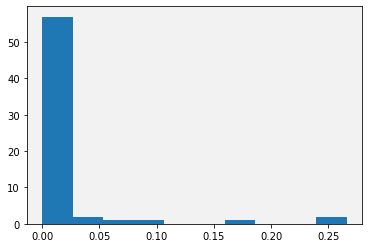

In [ ]:
plt.hist(products[1,:])

In [ ]:
products[np.arange(10000),np.argsort(products[:,:],1)[:,-1]]

array([0.76756538, 0.26591043, 0.63942629, ..., 0.46874392, 0.551196  ,
       0.42305356])

(array([ 114.,  601., 1144., 1334., 1150., 1034., 2006., 1514., 1035.,
          68.]),
 array([0.13263588, 0.21174084, 0.29084581, 0.36995077, 0.44905574,
        0.5281607 , 0.60726566, 0.68637063, 0.76547559, 0.84458055,
        0.92368552]),
 <BarContainer object of 10 artists>)

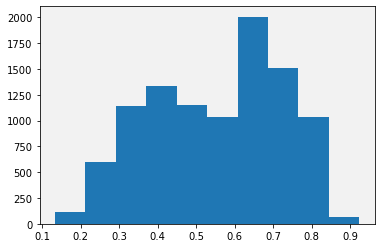

In [ ]:
plt.hist(np.max(products,1))

In [ ]:
_mu = tree._forward(data)

In [ ]:
_mu

tensor([[0.3386, 0.2929, 0.3329,  ..., 0.3041, 0.2554, 0.2673],
        [0.3213, 0.2730, 0.2849,  ..., 0.3193, 0.3248, 0.3227],
        [0.3877, 0.3433, 0.3294,  ..., 0.2076, 0.2978, 0.2971],
        ...,
        [0.3469, 0.3027, 0.3060,  ..., 0.3246, 0.3007, 0.3511],
        [0.3990, 0.2414, 0.3346,  ..., 0.3070, 0.2976, 0.3741],
        [0.2997, 0.2490, 0.2828,  ..., 0.3512, 0.3851, 0.4081]],
       grad_fn=<IndexBackward>)

In [ ]:
torch.max(_mu,1).

torch.return_types.max(
values=tensor([0.7676, 0.2659, 0.6394,  ..., 0.4687, 0.5512, 0.4231],
       dtype=torch.float64, grad_fn=<MaxBackward0>),
indices=tensor([ 0, 23, 16,  ..., 59, 58, 55]))

In [ ]:
target[10]

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

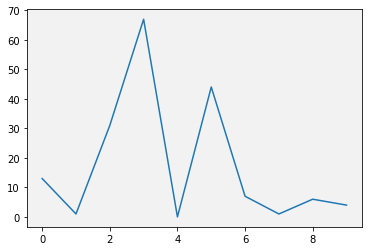

In [ ]:
plt.plot(tree.leaf_nodes[10].detach().numpy())

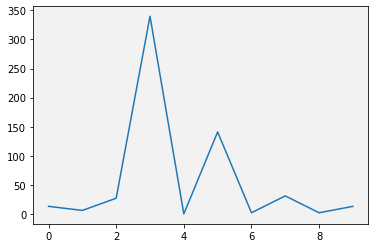

In [ ]:
plt.plot(tree.leaf_nodes[8].detach().numpy())

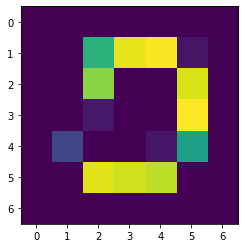

In [ ]:
plt.imshow(data[10,:].reshape(7,7))

In [ ]:
X_train_resize.shape

(60000, 49)

In [ ]:
clf.tree_.feature

array([350, 568, 430, ..., 405,  -2,  -2], dtype=int64)

In [ ]:
pd.read_excel('')